<a href="https://colab.research.google.com/github/haiderzm/GANs/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [49]:
class Discriminator(nn.Module):
  def __init__(self, channel_img, feature_d):
    super(Discriminator, self).__init__()
    self.disc = nn.Sequential(
        # 64 x 64
        nn.Conv2d(channel_img, feature_d, kernel_size=4, stride=2, padding=1), # 32 x 32
        nn.LeakyReLU(0.2),

        self._block(feature_d, feature_d*2, 4, 2, 1), # 16 x 16
        self._block(feature_d*2, feature_d*4, 4, 2, 1), # 8 x 8
        self._block(feature_d*4, feature_d*8, 4, 2, 1), # 4 x 4

        nn.Conv2d(feature_d*8, 1, kernel_size=4, stride=2, padding=0),
        nn.Sigmoid()
    )

  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.Conv2d(
            in_channels,
            out_channels, 
            kernel_size,
            stride,
            padding,
            bias = False
        ),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2),
    )

  def forward(self, x):
    return self.disc(x)

In [50]:
disc = Discriminator(3, 64)
disc

Discriminator(
  (disc): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(2, 2))
    (6): Sigmoid()
  )
)

In [51]:
x = torch.rand(10, 3, 64, 64)
out = disc(x)
print(out.shape)

torch.Size([10, 1, 1, 1])


In [52]:
class Generator(nn.Module):
  def __init__(self, channel_noise, channel_img, feature_g):
    super(Generator, self).__init__()
    self.gen = nn.Sequential(
        # N x dim x 1 x 1
        self._block(channel_noise, feature_g*16, 4, 1, 0), # 4x4
        self._block(feature_g*16, feature_g*8, 4, 2, 1), # 8x8
        self._block(feature_g*8, feature_g*4, 4, 2, 1), # 16x16
        self._block(feature_g*4, feature_g*2, 4, 2, 1), # 32x32

        nn.ConvTranspose2d(feature_g*2, channel_img, 4, 2, 1), # 64x64
        nn.Tanh()
    )

  def _block(self, in_channels, out_channels, kernel_size, stride, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels,
                           out_channels,
                           kernel_size,
                           stride,
                           padding,
                           bias=False
                           ),
        nn.BatchNorm2d(out_channels),
        nn.LeakyReLU(0.2)
    )
  
  def forward(self, x):
    return self.gen(x)

In [53]:
gen = Generator(100, 3, 64)
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_

In [54]:
latent = torch.randn(10,100,1,1)
out = gen(latent)
print(out.shape)

torch.Size([10, 3, 64, 64])


### Data

In [ ]:
! pip install kaggle

In [57]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [58]:
! cp kaggle.json ~/.kaggle/

In [59]:
! chmod 600 ~/.kaggle/kaggle.json

In [60]:
! kaggle datasets download jessicali9530/celeba-dataset

celeba-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [61]:
! unzip celeba-dataset.zip

Archive:  celeba-dataset.zip
replace img_align_celeba/img_align_celeba/000001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N



In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 2e-4  
BATCH_SIZE = 64
IMAGE_SIZE = 64
CHANNELS_IMG = 3
NOISE_DIM = 100
NUM_EPOCHS = 20
FEATURES_DISC = 64
FEATURES_GEN = 64

In [63]:
transforms = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
        ),
    ]
)


In [64]:
dataset = datasets.ImageFolder(root="img_align_celeba", transform=transforms)

In [65]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([64, 3, 78, 64])


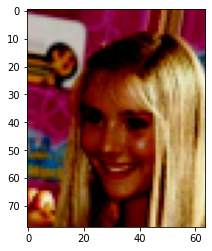

In [66]:
for img, _ in dataloader:
  print(img.shape)
  plt.imshow(img[1].permute(1,2,0))
  break

In [70]:
def deNorm(img):
  return img * 0.5 + 0.5

In [67]:
def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(10,10))
  ax.set_xticks([]) 
  ax.set_yticks([])
  ax.imshow(torchvision.utils.make_grid(deNorm(images[:nmax]), nrow=8).permute(1,2,0))

In [68]:
def show_batch(dl, nmax=64):
    for images, _ in dl:
        print(images.detach()[:nmax].shape)
        show_images(images, nmax)
        break

torch.Size([64, 3, 78, 64])


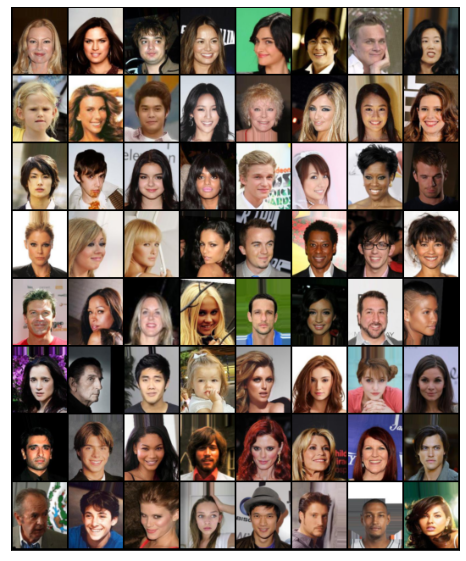

In [71]:
show_batch(dataloader)

In [82]:
gen = Generator(NOISE_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)

In [73]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [74]:
fixed_noise = torch.randn(32, NOISE_DIM, 1, 1).to(device)

In [75]:
sample_dir = 'generated'
import os
os.makedirs(sample_dir, exist_ok=True)

In [76]:
def save_samples(index, latent_tensors, show=True):
  fake_images = gen(latent_tensors)
  print(fake_images.shape)
  fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
  torchvision.utils.save_image(deNorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
  print('Saving', fake_fname)
  if show:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

torch.Size([64, 100, 1, 1])
torch.Size([64, 1, 64, 64])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


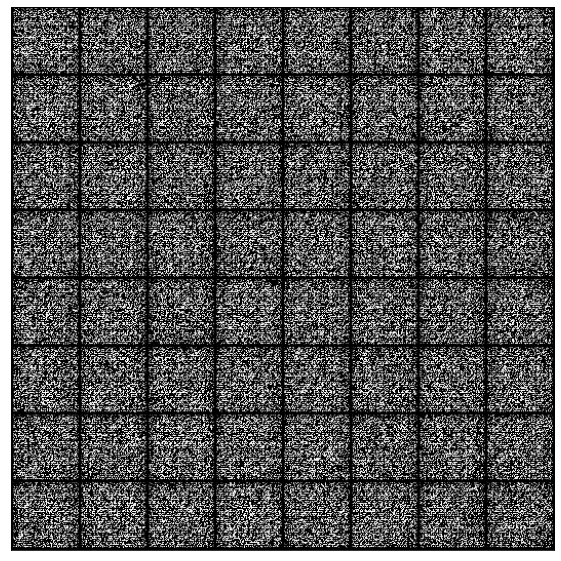

In [79]:
fixed_latent = torch.randn(64, NOISE_DIM, 1,1, device=device)
print(fixed_latent.shape)
save_samples(0, fixed_latent)

In [ ]:
for e in range(NUM_EPOCHS):
  for real, _ in dataloader:
    real = real.to(device)
    noise = torch.randn(BATCH_SIZE, NOISE_DIM, 1, 1).to(device)
    fake = gen(noise)

    # Train Discriminator
    disc_real = disc(real).view(-1)
    loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))

    disc_fake = disc(fake.detach()).view(-1)
    loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

    loss_disc = (loss_disc_real + loss_disc_fake)/2

    disc.zero_grad()
    loss_disc.backward()
    opt_disc.step()

    # Train Generator
    output = disc(fake).view(-1)
    loss_gen = criterion(output, torch.ones_like(output))

    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()
  save_samples(e+1, fixed_latent)